In [19]:
import gymnasium as gym
import torch
from torch.autograd import Variable
import torch.nn as nn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
import copy
import numpy as np
from collections import namedtuple

In [20]:
class DQN():
    def __init__(self, input, output, hidden_count, lr):
        self.model = nn.Sequential(
            nn.Linear(input, hidden_count),
            nn.ReLU(),
            nn.Linear(hidden_count, hidden_count),
            nn.ReLU(),
            nn.Linear(hidden_count, output),
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        #self.criterion = torch.nn.SmoothL1Loss()

    def update(self, state):
        return self.model(torch.Tensor(state))


#    def optimize(self, q_val, ext_q_val):
#        loss = self.criterion(torch.Tensor(q_val), torch.Tensor(ext_q_val).unsqueeze(1))
#        self.optimizer.zero_grad()
#        loss.backward()
#        self.optimizer.step()

    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    def save(self, file_name):
        torch.save(self.model, file_name)

    def set_dict(self, in_model):
        self.model.load_state_dict(in_model.model.state_dict())

In [21]:
def greedy_policy(agent, eps, action_count):
    def policy(stage):
        if random.random() < eps:
            return random.randint(0, action_count - 1)
        else:
            q_val = agent.predict(stage)
            return torch.argmax(q_val).item()
    return policy

In [22]:
class Parameters():
    def __init__(self
                 , episode_count = 1
                 , episode_update = 1
                 , replay_size = 1
                 , epsilone = 0.1
                 , epsilon_decay = 1.
                 , gamma = 1.
                 , tau = 0.001
                                        ):
        self.episode_count = episode_count
        self.episode_update = episode_update
        self.replay_size = replay_size
        self.epsilone = epsilone
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.memlength = episode_count
        self.tau = tau


In [23]:
def modern_reward(state, new_state, new_reward):
    
    #new_reward += (
    #- 100 * (new_state[0] - state[0])   # X, 
    #- 100 * (new_state[1] - state[1])   # Y, 
    #- 100 * (new_state[2] - state[2])   # Vx,
    #- 100 * (new_state[3] - state[3]))   # Vy,
    
    #new_reward += - 1 * abs(new_state[3])
    #
    #new_reward += - 10 * abs(new_state[5])   # Vθ,
    #new_reward += - 1 * abs(new_state[4])   # θ, 
    #new_reward += (50 * (new_state[6])   # Л
    #            +  50 * (new_state[7]))  # П

    return new_reward

In [29]:
def q_learning(params, env, seed, action_count, agent_policy, agent_target, optimizer):
    
    #сброс генератора случайных чисел
    env.reset(seed=seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # суммарная награда в каждом эпизоде
    total_reward_episode = np.zeros(params.episode_count)
    # буффер действий состояний и наград
    memory = deque(maxlen=params.memlength)
    
    epsilone = params.epsilone

    for n in tqdm(range(params.episode_count)):

        state, _ = env.reset(seed=seed)

        policy = greedy_policy(agent_policy, epsilone, action_count)

        is_done = False
        is_break = False

        while not is_done and not is_break:
            action = policy(state)

            new_state, reward, is_done, is_break, _ = env.step(action)

            reward = modern_reward(state, new_state, reward)

            memory.append((state,action,new_state,reward,(is_done or is_break)))

            if len(memory) > params.replay_size:
                replay_mem = random.sample(memory, params.replay_size)
                #states = []
                q_values_t = []
                q_values_t1 = []

                # обучение целевой сети на быче 
                for m_state,m_action,m_new_state,m_reward, m_done in replay_mem:
                    #states.append(m_state)
                    q_value = agent_policy.update(m_state).tolist()
                    q_values_t.append(q_value[m_action])
                    # финальные состояния не используются
                    if m_done == False:
                        q_value_new = agent_target.predict(m_new_state).detach()
                        q_value[m_action] = m_reward + params.gamma * torch.argmax(q_value_new).item()
                        q_values_t1.append(q_value[m_action])
                    else:
                        q_values_t1.append(0)

                #agent_policy.optimize(q_values_t, q_values_t1)

                q_values_t = torch.Tensor([q_values_t])
                q_values_t1= torch.Tensor([q_values_t1])

                criterion = nn.SmoothL1Loss()
                loss = criterion(q_values_t, q_values_t1)

                # Готовим градиент
                optimizer.zero_grad()
                loss.backward()
                # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
                torch.nn.utils.clip_grad_value_(agent_policy.parameters(), 100)
                
                optimizer.step()

                # делаем "мягкое" обновление весов
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = agent_target.model.state_dict()
                policy_net_state_dict = agent_policy.model.state_dict()
                
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*params.tau + target_net_state_dict[key]*(1-params.tau)
                agent_target.model.load_state_dict(target_net_state_dict)


            state = new_state

            total_reward_episode[n] += reward

        epsilone = max(epsilone * params.epsilon_decay, 0.01)

    return total_reward_episode

In [25]:
env = gym.envs.make("LunarLander-v2")

In [26]:
env.observation_space
#  X, координата посадочного модуля,
#  Y, координата посадочного модуля
#  Vx, горизонтальная скорость
#  Vy, вертикальная скорость
#  θ, ориентация в пространстве
#  Vθ, угловая скорость
#  Ллевая стойка касается земли (да/нет)
#  Правая стойка касается земли (да/нет)

Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

In [30]:
params = Parameters(episode_count=200, 
                    episode_update=10, 
                    replay_size=20, 
                    epsilone=0.3, 
                    epsilon_decay=0.99, 
                    gamma=0.99,
                    tau=0.005)



seed = 42
last_episode = 100

# варианты обучения агента
variant = namedtuple('variant', ['n_hidden', 'lr', 'replay_size','episode_update'])
n_variant = []
n_hidden_options = [64, 256]       # количество нейронов в скрытом слое
lr_options = [0.002, 0.003]         # скорость обучения агента
replay_size_options = [64, 128]     # количество записей в баче
episode_update_options = [32, 64]   # период обновления целевой сети

for n_hidden in n_hidden_options:
    for lr in lr_options:
        for replay_size in replay_size_options:
            for episode_update in episode_update_options:
                n_variant.append(variant(
                    n_hidden=n_hidden,
                    lr=lr,
                    replay_size=replay_size,
                    episode_update=episode_update
                ))

action_count = env.action_space.n
state_count = env.observation_space.shape[0]

total_reward_episode_end = []

#for n_hidden, lr, replay_size, episode_update in n_variant:
if True:
    n_hidden, lr, replay_size, episode_update = n_variant[0]
    
    params.replay_size = replay_size
    params.episode_update = episode_update

    # агент политики и целевой агент
    agent_policy = DQN(state_count, action_count, n_hidden, lr)
    agent_target = DQN(state_count, action_count, n_hidden, lr)
    # передача коеффициентов из агента политики в целевой агент
    agent_target.set_dict(agent_policy)

    # Задать оптимайзер
    optimizer = torch.optim.AdamW(agent_policy.model.parameters(), lr=lr, amsgrad=True)

    # обучение сети
    total_reward_episode = q_learning(params, env, seed, action_count, agent_policy, agent_target, optimizer)

    print(n_hidden, lr, replay_size, episode_update, sum(total_reward_episode[-last_episode:])/last_episode)
    total_reward_episode_end = total_reward_episode


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:43<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
agent_target.save('../agents/lunar_lander_v2_dqn.pth')

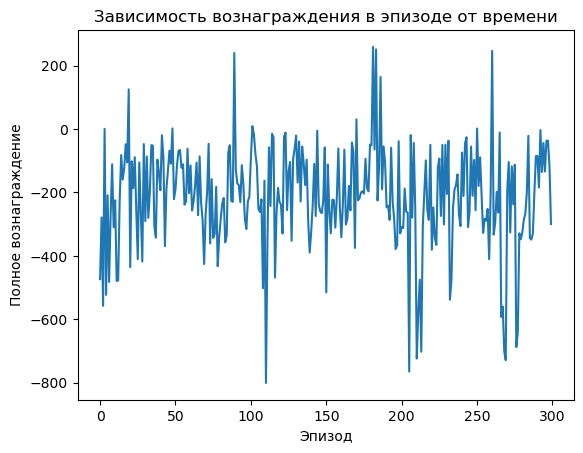

In [ ]:
plt.plot(total_reward_episode_end)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [ ]:
reward_end_episode = total_reward_episode_end[-last_episode:]
sum(reward_end_episode)/last_episode

-250.10471410717219

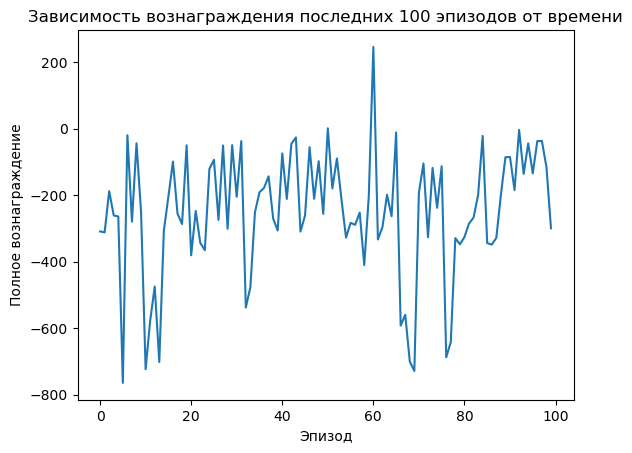

In [ ]:
plt.plot(reward_end_episode)
plt.title('Зависимость вознаграждения последних {} эпизодов от времени'.format(last_episode))
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()